In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim

In [ ]:
!pip install tensorboard
import gensim.downloader as api
import os
import pandas as pd
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Dataset

In [ ]:
class CustomEEGDataset(Dataset):
    def __init__(self, sentence_mapping, eeg_path, pad_len=5500, dtype=torch.float32):
        self.records = pd.read_csv(sentence_mapping)
        self.records = self.records.reset_index(drop=True)
        self.eeg_path = Path(eeg_path)
        self.pad_len = int(pad_len)
        self.dtype = dtype

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx: int):
        row = self.records.iloc[idx]
        uuid = row["UniqueID"]
        sentence = row["Content"]

        eeg = self._load_and_pad_eeg(uuid)  # [105, T] -> [105, pad_len]
        # Return tensors without batch dimension; DataLoader will stack them
        return {
            "uuid": uuid,
            "sentence": sentence,        # stays as string; DataLoader will make a list of strings
            "eeg": eeg                   # torch.FloatTensor [105, pad_len]
        }

    def _load_and_pad_eeg(self, uuid: str) -> torch.Tensor:
        path = self.eeg_path / f"{uuid}.csv"
        if not path.exists():
            raise FileNotFoundError(f"EEG file not found: {path}")

        # Expect shape [channels=105, timesteps]; adjust if your CSV is transposed
        df = pd.read_csv(path)
        arr = df.values.astype(np.float32)

        # If CSV is [T, 105] instead of [105, T], transpose:
        if arr.shape[0] == 5500 and arr.shape[1] == 105:  # heuristic; change to your rule
            arr = arr.T

        # Pad or crop to pad_len along time axis (axis=1)
        c, t = arr.shape
        if c != 105:
            raise ValueError(f"Expected 105 channels, got {c} in {path}")

        if t < self.pad_len:
            pad = np.zeros((c, self.pad_len - t), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=1)
        elif t > self.pad_len:
            arr = arr[:, :self.pad_len]

        return torch.from_numpy(arr).to(self.dtype)  # [105, pad_len]


# ENCODER - EEG to CODEX

In [ ]:
class ConvolutionModel(nn.Module):
    '''
    Input : single sentence EEG raw input of (105 channels, 5500 timestamps)
    Output : single sentence of 57 features of 512 dimensions embedding each
    '''
    def __init__(self):
        super().__init__()
        self.convolutional_model = nn.Sequential(
            nn.Conv1d(in_channels=105, kernel_size=10, out_channels=64, stride=3),
            nn.Conv1d(in_channels=64,  kernel_size=3,  out_channels=128, stride=2),
            nn.Conv1d(in_channels=128, kernel_size=3,  out_channels=256, stride=2),
            nn.Conv1d(in_channels=256, kernel_size=3,  out_channels=512, stride=2),
            nn.Conv1d(in_channels=512, kernel_size=2,  out_channels=512, stride=2),
            nn.Conv1d(in_channels=512, kernel_size=2,  out_channels=512, stride=2),
        )

    def forward(self, x):
        # Input shape expected: [batch_size, channels, timestamps]
        op = self.convolutional_model(x)
        # Output shape is [batch_size, d_model, num_tokens] -> transpose to [batch_size, num_tokens, d_model]
        return op.permute(0, 2, 1)

In [ ]:
class AttentionBlock(nn.Module):
    """
    Single-head scaled dot-product attention using nn.Linear layers.
    """
    def __init__(self, d_model, d_k):
        super().__init__()
        self.d_k = d_k
        self.W_Q = nn.Linear(d_model, d_k, bias=False)
        self.W_K = nn.Linear(d_model, d_k, bias=False)
        self.W_V = nn.Linear(d_model, d_k, bias=False)

    def forward(self, x):
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        output = attn_weights @ V
        return output

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model, heads=8):
        super().__init__()
        self.heads = heads
        self.d_model = d_model
        # d_k is the dimension of each head. Must be divisible by d_model
        self.d_k = d_model // heads

        # Use nn.ModuleList to register attention blocks with PyTorch
        self.attentionBlocks = nn.ModuleList([AttentionBlock(d_model, self.d_k) for _ in range(self.heads)])

        # Final linear layer to project concatenated heads back to d_model dimension
        self.output_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        head_outputs = []
        for block in self.attentionBlocks:
            # Assuming x is [batch_size, num_tokens, d_model]
            out_h = block(x) # [batch_size, num_tokens, d_k]
            head_outputs.append(out_h)

        # Concatenate along the last dimension
        total = torch.cat(head_outputs, dim=-1) # [batch_size, num_tokens, d_model]

        # Apply final linear layer
        output = self.output_linear(total)
        return output

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model=512, heads=8, beta=0.2):
        super().__init__()
        self.conv = ConvolutionModel()
        self.mha = MultiHeadAttentionBlock(d_model=d_model, heads=heads)
        self.codex = nn.Embedding(num_embeddings=2048, embedding_dim=512)
        self.words = self.codex.weight  # codebook
        self.beta = beta               # commitment weight

    def forward(self, x):
        """
        x: [batch_size, 105, 5500]

        returns:
            z_q_st: [batch_size, 57, 512]  (quantized, straight-through)
            vq_loss: scalar (codebook + commitment terms)
            indices: [batch_size, 57]  (chosen code indices)
        """
        # conv_output: [batch_size, 57, 512]
        conv_output = self.conv(x)

        # attn_output: [batch_size, 57, 512] (this is z_c in VQ-VAE terms)
        attn_output = self.mha(conv_output)

        # --- vector quantization using your codex / words ---
        B, L, D = attn_output.shape  # [B, 57, 512]

        # make codebook shape [1, 2048, 512] so cdist works: [B, 57, 512] x [1, 2048, 512] -> [B, 57, 2048]
        codebook = self.words.unsqueeze(0)  # [1, 2048, 512]
        distances = torch.cdist(attn_output, codebook)  # [B, 57, 2048]

        # indices of the least-distance codex word for each EEG feature
        indices = torch.argmin(distances, dim=-1)  # [B, 57]

        # quantized vectors via embedding lookup
        z_q = self.codex(indices)  # [B, 57, 512]

        # --- VQ codebook + commitment losses ---

        # codebook loss: || sg[attn_output] - z_q ||^2  (update codex/words)
        codebook_loss = F.mse_loss(z_q, attn_output.detach())

        # commitment loss: || attn_output - sg[z_q] ||^2  (update encoder)
        commitment_loss = F.mse_loss(attn_output, z_q.detach())

        vq_loss = codebook_loss + self.beta * commitment_loss

        # straight-through: forward uses z_q, grads go to attn_output
        z_q_st = attn_output + (z_q - attn_output).detach()

        return z_q_st, vq_loss, indices

# DECODER - self reconstruction

In [ ]:
class DeConvolutionModel(nn.Module):
    """
    Input  (to this block): [B, 512, 57]
    Output (from this block): [B, 105, 5500]
    """
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=512, out_channels=512, kernel_size=2, stride=2),  # 57 -> 114
            nn.ConvTranspose1d(in_channels=512, out_channels=512, kernel_size=2, stride=2),  # 114 -> 228
            nn.ConvTranspose1d(in_channels=512, out_channels=256, kernel_size=3, stride=2),  # 228 -> 457
            nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=3, stride=2),  # 457 -> 915
            nn.ConvTranspose1d(in_channels=128, out_channels=64,  kernel_size=3, stride=2),  # 915 -> 1831
            nn.ConvTranspose1d(in_channels=64,  out_channels=105, kernel_size=10, stride=3), # 1831 -> 5500
        )

    def forward(self, x):
        return self.deconv(x)  # [B, 105, 5500]

class Decoder(nn.Module):
    def __init__(self, d_model=512, heads=8):
        super().__init__()
        self.mha = MultiHeadAttentionBlock(d_model=d_model, heads=heads)  # keeps [B, 57, 512]
        self.deconv = DeConvolutionModel()

    def forward(self, x):
        # x: [B, 57, 512]
        attn_out = self.mha(x)                 # [B, 57, 512]
        attn_out = attn_out.permute(0, 2, 1)   # -> [B, 512, 57]  (channels = 512, length = 57)
        out = self.deconv(attn_out)            # -> [B, 105, 5500]
        return out


# WORD2VEC - converting sentences to embeddings

In [ ]:
class Word2VecModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.w2v = api.load('word2vec-google-news-300')
        self.linear = nn.Linear(300, 512)
        self.unk_vector = torch.zeros(300)  # vector for unknown words

    def forward(self, sentence_tokens):
      """
      sentence_tokens: list of tokens (strings)
      returns: [num_words, 512] tensor
      """
      device = self.linear.weight.device

      vectors = []
      for word in sentence_tokens:
          if word in self.w2v:
              vec = torch.tensor(self.w2v[word], dtype=torch.float32, device=device)
          else:
              vec = self.unk_vector.to(device)
          vectors.append(vec)

      emb = torch.stack(vectors)              # [num_words, 300]
      enh_emb = self.linear(emb)              # [num_words, 512]

      z_t_interpolated = F.interpolate(
          enh_emb.transpose(0, 1).unsqueeze(0),  # [1, 512, num_words]
          size=57,                               # Match EEG length
          mode='linear',
          align_corners=True
      ).squeeze(0).transpose(0, 1)  # [57, 512]

      return z_t_interpolated


# Training Loop

In [ ]:
def nt_xent_loss(out, target, temperature=0.07):
  zq = F.normalize(out,dim=1)
  zt = F.normalize(target,dim=1)

  logits = zq @ zt.T / temperature #Build similarity matrix. Smaller τ → make similarities more “peaked” → harder classification → stronger gradients.

  labels = torch.arange(logits.shape[0], device=logits.device)
  #For row 0: the correct target index is 0 → wants softmax to choose column 0 and so on for all the rows

  loss = F.cross_entropy(logits, labels)
  return loss

In [ ]:
CKPT_DIR = "/content/drive/MyDrive/EEG_dataset/NewCheckpoints"  # or just "checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

def save_checkpoint(epoch, encoder, decoder, w2v, optimizer,
                    avg_total, avg_recon, avg_vq, avg_contrast,
                    path):
    state = {
        "epoch": epoch,
        "encoder_state": encoder.state_dict(),
        "decoder_state": decoder.state_dict(),
        "w2v_state": w2v.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "avg_total": avg_total,
        "avg_recon": avg_recon,
        "avg_vq": avg_vq,
        "avg_contrast": avg_contrast,
    }
    torch.save(state, path)
    print(f"[Checkpoint] Saved to {path}")



def load_checkpoint(path, encoder, decoder, w2v, optimizer=None, map_location="cpu"):
    checkpoint = torch.load(path, map_location=map_location)

    encoder.load_state_dict(checkpoint["encoder_state"])
    decoder.load_state_dict(checkpoint["decoder_state"])
    w2v.load_state_dict(checkpoint["w2v_state"])

    if optimizer is not None and "optimizer_state" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state"])

    epoch = checkpoint.get("epoch", 0)
    avg_total = checkpoint.get("avg_total", None)
    avg_recon = checkpoint.get("avg_recon", None)
    avg_vq = checkpoint.get("avg_vq", None)
    avg_contrast = checkpoint.get("avg_contrast", None)

    print(f"[Checkpoint] Loaded from {path} (epoch {epoch})")
    return epoch, avg_total, avg_recon, avg_vq, avg_contrast


In [ ]:
def train_one_epoch(epoch_index):
    ALPHA = 1.0   # weight for contrastive loss
    encoder.train()
    decoder.train()
    w2v.train()

    running_total = 0.0
    running_recon = 0.0
    running_vq = 0.0
    running_contrast = 0.0

    for i, data in enumerate(dataloader):
        sentences = data["sentence"]          # list of B strings
        eeg = data["eeg"].to(device)          # [B, 105, 5500]

        # 1) EEG -> encoder with VQ
        z_q, vq_loss, indices = encoder(eeg)  # [B, 57, 512], scalar

        # 2) EEG reconstruction
        predictions = decoder(z_q)            # [B, 105, 5500]
        reconstruction_loss = F.mse_loss(predictions, eeg)

        # 3) Text embeddings (Word2Vec per sentence)
        text_embeddings_list = [w2v(s.split()) for s in sentences]  # each [57, 512]
        text_embeddings = torch.stack(text_embeddings_list, dim=0)  # [B, 57, 512]

        # 4) Pool and contrastive loss
        z_q_pooled = z_q.mean(dim=1)               # [B, 512]
        text_pooled = text_embeddings.mean(dim=1)  # [B, 512]

        contrastive_loss = nt_xent_loss(z_q_pooled, text_pooled)

        # 5) Combine losses
        L_wave = 0.5*reconstruction_loss + 0.5*vq_loss
        loss = L_wave + ALPHA*contrastive_loss          # you can later scale terms

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_total += loss.item()
        running_recon += reconstruction_loss.item()
        running_vq += vq_loss.item()
        running_contrast += contrastive_loss.item()

    num_batches = len(dataloader)
    avg_total = running_total / num_batches
    avg_recon = running_recon / num_batches
    avg_vq = running_vq / num_batches
    avg_contrast = running_contrast / num_batches

    return avg_total, avg_recon, avg_vq, avg_contrast


In [ ]:
sentence_mapping = '/content/drive/MyDrive/EEG_dataset/dataset/sentence_mapping.csv'
eeg_path = '/content/drive/MyDrive/EEG_dataset/dataset'

# hyperparams
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
encoder = Encoder().to(device)
decoder = Decoder().to(device)
w2v = Word2VecModel().to(device)

# dataset & dataloader
dataset = CustomEEGDataset(
    sentence_mapping=sentence_mapping,
    eeg_path=eeg_path,
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# optimizer
optimizer = torch.optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(w2v.parameters()),
    lr=LR
)

# --------- OPTIONAL: resume from an existing checkpoint ---------
resume = False
resume_path = "/content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_26.pt"

start_epoch = 0
if resume:
    start_epoch, last_loss = load_checkpoint(
        path=resume_path,
        encoder=encoder,
        decoder=decoder,
        w2v=w2v,
        optimizer=optimizer,
    )
    print(f"Resuming from epoch {start_epoch} with loss = {last_loss:.4f}")

# --------- history dict to log losses for plotting ---------
history = {
    "epoch": [],
    "total": [],
    "recon": [],
    "vq": [],
    "contrast": [],
}

# --------- Training loop ---------
for epoch in range(start_epoch + 1, EPOCHS):
    avg_total, avg_recon, avg_vq, avg_contrast = train_one_epoch(epoch_index=epoch)

    # save into history
    history["epoch"].append(epoch)
    history["total"].append(avg_total)
    history["recon"].append(avg_recon)
    history["vq"].append(avg_vq)
    history["contrast"].append(avg_contrast)

    # console logging
    print(
        f"Epoch [{epoch + 1}/{EPOCHS}] | "
        f"total: {avg_total:.4f} | "
        f"recon: {avg_recon:.4f} | "
        f"vq: {avg_vq:.4f} | "
        f"contrast: {avg_contrast:.4f}"
    )

    # save checkpoint for this epoch
    save_checkpoint(
        epoch=epoch,
        encoder=encoder,
        decoder=decoder,
        w2v=w2v,
        optimizer=optimizer,
        avg_total = avg_total,
        avg_recon = avg_recon,
        avg_vq = avg_vq,
        avg_contrast = avg_contrast,
        path=f"/content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_{epoch}.pt"
    )

# --------- after training: save the history so you can plot later ---------
import pandas as pd

log_path = "/content/drive/MyDrive/EEG_dataset/NewCheckpoints/training_log.csv"
pd.DataFrame(history).to_csv(log_path, index=False)
print(f"Saved loss history to {log_path}")


Epoch [2/50] | total: 11.8750 | recon: 13.4513 | vq: 3.3741 | contrast: 3.4623
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_1.pt
Epoch [3/50] | total: 11.3614 | recon: 13.3610 | vq: 2.4890 | contrast: 3.4365
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_2.pt
Epoch [4/50] | total: 84115.6715 | recon: 13.7103 | vq: 168210.7006 | contrast: 3.4662
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_3.pt
Epoch [5/50] | total: 1549.0768 | recon: 13.7070 | vq: 3077.5331 | contrast: 3.4567
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_4.pt
Epoch [6/50] | total: 476.0300 | recon: 13.7066 | vq: 931.4492 | contrast: 3.4521
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_5.pt
Epoch [7/50] | total: 507.5391 | recon: 13.7010 | vq: 994.4593 | contrast: 3.4590
[Checkpoint] Saved to /content/drive/MyDrive/EEG_dataset/NewCheckpoints/epoch_6.pt
Epoch [8/

# Plot the loss graph

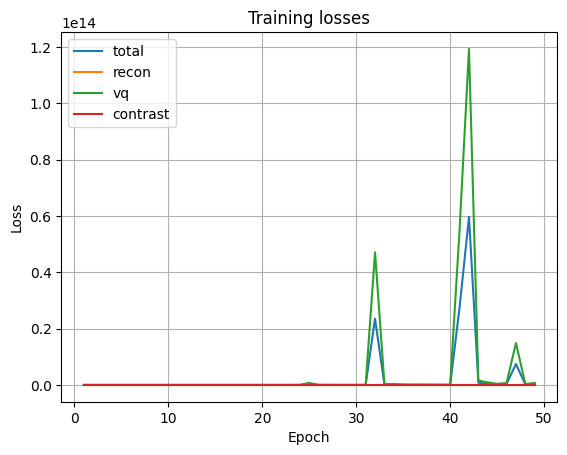

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = "/content/drive/MyDrive/EEG_dataset/NewCheckpoints/training_log.csv"
df = pd.read_csv(log_path)

plt.figure()
plt.plot(df["epoch"], df["total"], label="total")
plt.plot(df["epoch"], df["recon"], label="recon")
plt.plot(df["epoch"], df["vq"], label="vq")
plt.plot(df["epoch"], df["contrast"], label="contrast")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training losses")
plt.grid(True)
plt.show()
